# Imports
Import the necessary packages. We import **janssen** as `jns`. 

In [1]:
import janssen as jns
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

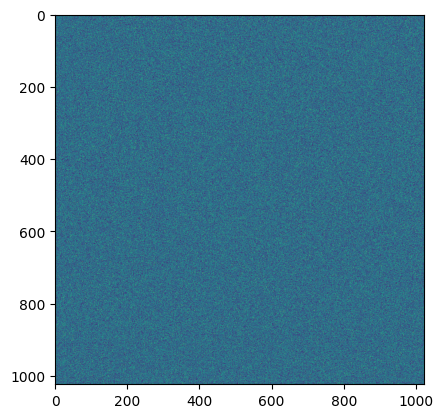

In [2]:
random_image = (np.abs(np.reshape(np.random.randn(1024**2), (1024, 1024))))**0.5
plt.imshow(random_image)

In [3]:
im_jax = jnp.tile(jnp.sin(np.arange(start=0, stop=16*jnp.pi, step=jnp.pi/64)), (1024, 1))
random_wave = jnp.asarray(random_image, dtype=jnp.complex128)
random_wave = random_wave/jnp.max(jnp.abs(random_wave))

JIT compile the function(s) to be called.

In [4]:
make_optical_wavefront = jax.jit(jns.utils.make_optical_wavefront)
make_sample_function = jax.jit(jns.utils.make_sample_function)
linear_interaction = jax.jit(jns.simul.linear_interaction)
optical_zoom = jax.jit(jns.lenses.optical_zoom)
circular_aperture = jax.jit(jns.simul.circular_aperture)
fraunhofer_prop = jax.jit(jns.lenses.fraunhofer_prop)

In [5]:
wavelength = 533/(10^9)
dx = 3/(10**4)
optical_wave = make_optical_wavefront(random_wave, wavelength, dx, z_position=0.0)

In [6]:
sample_function = make_sample_function(im_jax, dx)

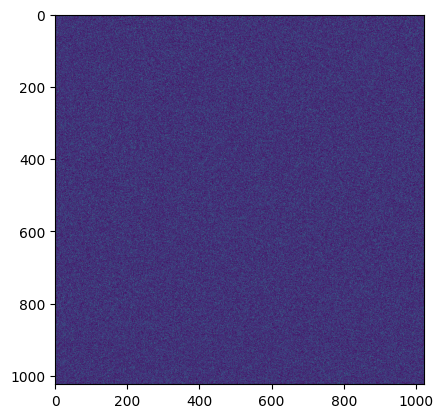

In [7]:
plt.imshow(jnp.abs(optical_wave.field)**2)

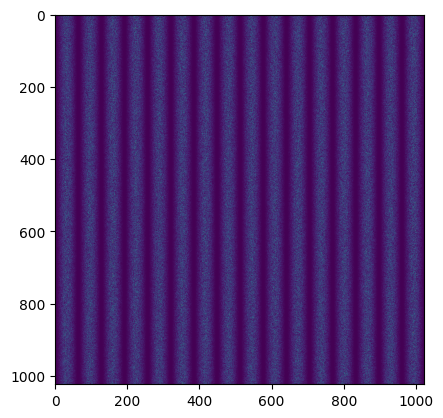

In [8]:
at_sample = linear_interaction(sample_function, optical_wave)
plt.imshow(jnp.abs(at_sample.field)**2)

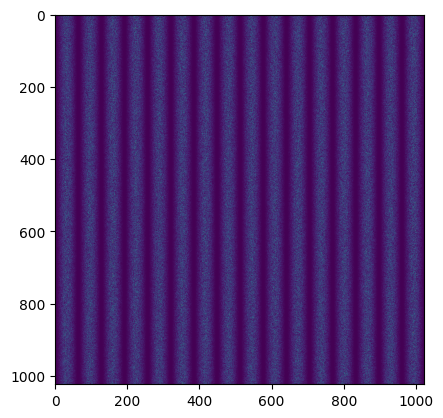

In [9]:
zoomed_wave = optical_zoom(at_sample, zoom_factor=9.7)
plt.imshow(jnp.abs(zoomed_wave.field)**2)

In [10]:
zoomed_wave.dx, at_sample.dx, optical_wave.dx, sample_function.dx, dx

(Array(0.00291, dtype=float64),
 Array(0.0003, dtype=float64),
 Array(0.0003, dtype=float64),
 Array(0.0003, dtype=float64),
 0.0003)

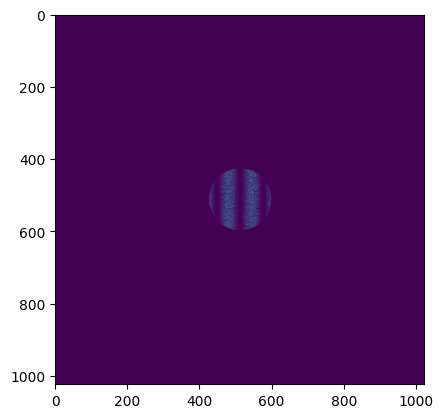

In [11]:
after_aperture = circular_aperture(zoomed_wave, diameter=0.5, center=jnp.array([0.0, 0.0]))
plt.imshow(jnp.abs(after_aperture.field)**2)

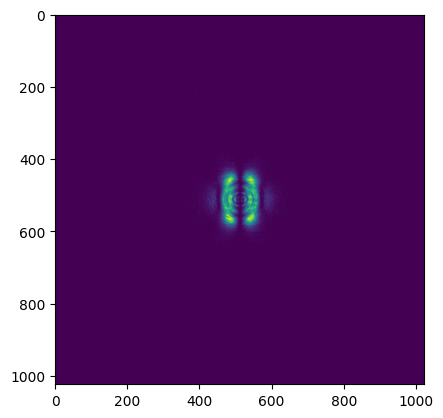

In [12]:
at_camera = fraunhofer_prop(after_aperture, 0.1)
plt.imshow(jnp.abs(at_camera.field)**2)